In [ ]:
import matplotlib.pyplot as plt
import pandas as pd
from IPython.display import Markdown, display

# Path to csv file
folder = "C:/Users/apins/Diplomka/VR_core/calib_log/"
file_name = "calib_"
file_id = "183138"

csv_path = f"{folder}{file_name}{file_id}.csv"

df = pd.read_csv(csv_path)

display(Markdown("### Preview of raw data"))
display(df.head())


### Preview of raw data

,marker_id,marker_type,distance,horizontal,vertical,eye,sample_index,dx,dy
0,1,REF,40.0,0.0,0.0,L,0,35.235979,-37.481715
1,1,REF,40.0,0.0,0.0,R,0,-67.112847,-49.413912
2,1,REF,40.0,0.0,0.0,L,1,33.997269,-37.688625
3,1,REF,40.0,0.0,0.0,R,1,-67.088826,-49.784072
4,1,REF,40.0,0.0,0.0,L,2,33.460709,-37.133301


In [18]:
# Ensure consistent ordering of marker types if you want
MARKER_TYPE_ORDER = ["REF", "DIST", "ANG"]

groups = []  # list of dicts: {"marker_type", "marker_id", "df_LR"}

for mtype in MARKER_TYPE_ORDER:
    df_mtype = df[df["marker_type"] == mtype]
    if df_mtype.empty:
        continue

    for mid in sorted(df_mtype["marker_id"].unique()):
        df_mid = df_mtype[df_mtype["marker_id"] == mid]

        # We want both eyes in the group
        if not {"L", "R"}.issubset(df_mid["eye"].unique()):
            continue

        # Split per eye and align by sample_index
        df_left = df_mid[df_mid["eye"] == "L"].sort_values("sample_index")
        df_right = df_mid[df_mid["eye"] == "R"].sort_values("sample_index")

        merged = pd.merge(
            df_left[["sample_index", "dx", "dy"]],
            df_right[["sample_index", "dx", "dy"]],
            on="sample_index",
            suffixes=("_L", "_R"),
            how="inner",
        )

        if merged.empty:
            continue

        groups.append(
            {
                "marker_type": mtype,
                "marker_id": mid,
                "df_LR": merged,
            }
        )

display(Markdown(f"### Number of (marker_type, marker_id) groups: **{len(groups)}**"))


### Number of (marker_type, marker_id) groups: **14**

In [19]:
# Global ranges for all dx and dy (L + R combined)
global_dx_min = df["dx"].min()
global_dx_max = df["dx"].max()

global_dy_min = df["dy"].min()
global_dy_max = df["dy"].max()

# Optional: add a small margin so curves are not glued to the frame
dx_margin = 0.05 * (global_dx_max - global_dx_min)
dy_margin = 0.05 * (global_dy_max - global_dy_min)

dx_ylim = (global_dx_min - dx_margin, global_dx_max + dx_margin)
dy_ylim = (global_dy_min - dy_margin, global_dy_max + dy_margin)

dx_ylim, dy_ylim


((-131.4595122923753, 96.70827456955726),
 (-76.57530789008501, 5.253452225520431))

In [20]:
def plot_group_dx_dy(group):
    """
    Plot dx and dy for one (marker_type, marker_id) group.
    Uses global, fixed y-limits for ALL graphs so they are directly comparable.
    """
    mtype = group["marker_type"]
    mid = group["marker_id"]
    data = group["df_LR"]

    x = data["sample_index"]

    dx_L = data["dx_L"]
    dx_R = data["dx_R"]
    dy_L = data["dy_L"]
    dy_R = data["dy_R"]

    fig, axes = plt.subplots(1, 2, figsize=(12, 4), sharex=True)
    fig.suptitle(f"{mtype} – Marker {mid}", fontsize=14)

    # ---- dx plot ----
    ax_dx = axes[0]
    ax_dx.plot(x, dx_L, label="dx L")
    ax_dx.plot(x, dx_R, label="dx R")
    ax_dx.set_xlabel("sample_index")
    ax_dx.set_ylabel("dx")
    ax_dx.set_ylim(dx_ylim)          # << global range
    ax_dx.legend()
    ax_dx.grid(True)

    # ---- dy plot ----
    ax_dy = axes[1]
    ax_dy.plot(x, dy_L, label="dy L")
    ax_dy.plot(x, dy_R, label="dy R")
    ax_dy.set_xlabel("sample_index")
    ax_dy.set_ylabel("dy")
    ax_dy.set_ylim(dy_ylim)          # << global range
    ax_dy.legend()
    ax_dy.grid(True)

    plt.tight_layout()
    plt.show()


## Marker type: **REF**, marker_id: **1**

**Data preview:**

,sample_index,dx_L,dy_L,dx_R,dy_R
0,0,35.235979,-37.481715,-67.112847,-49.413912
1,1,33.997269,-37.688625,-67.088826,-49.784072
2,2,33.460709,-37.133301,-67.153011,-49.406969
3,3,33.689047,-36.609164,-67.318640,-49.387234
4,4,32.739946,-37.101549,-67.311961,-48.924315


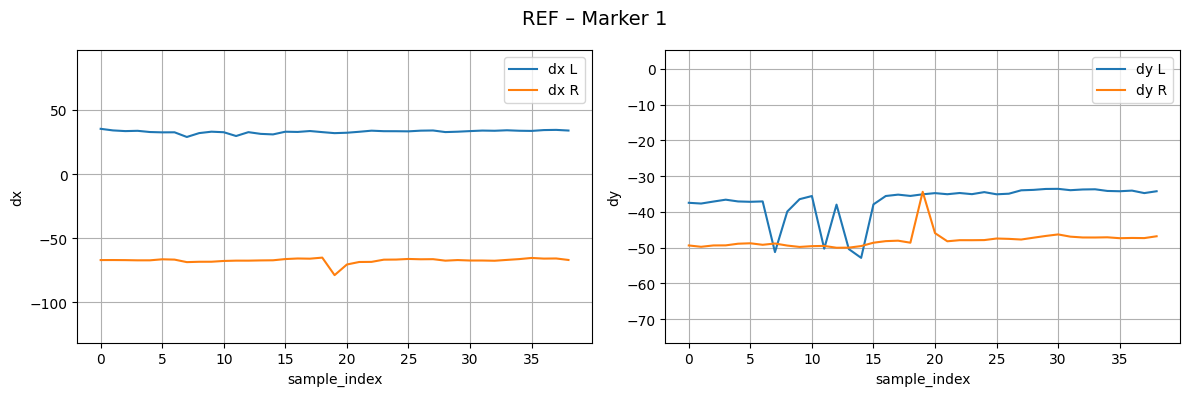

## Marker type: **DIST**, marker_id: **2**

**Data preview:**

,sample_index,dx_L,dy_L,dx_R,dy_R
0,0,34.542915,-34.228319,-66.031953,-47.490815
1,1,34.248668,-33.764565,-66.403792,-47.367160
2,2,33.639754,-33.213105,-66.535164,-46.655548
3,3,33.853538,-33.915954,-66.011726,-46.677236
4,4,34.546923,-33.803269,-67.314255,-46.587801


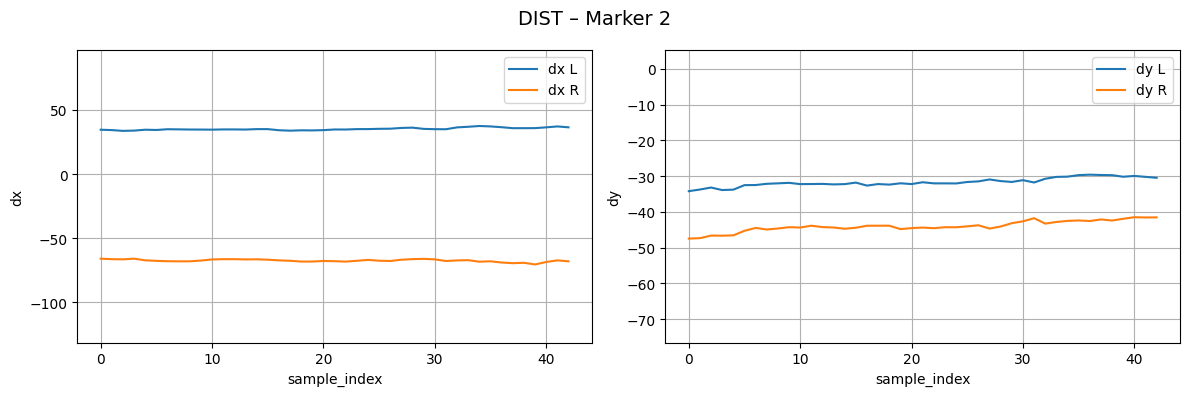

## Marker type: **DIST**, marker_id: **3**

**Data preview:**

,sample_index,dx_L,dy_L,dx_R,dy_R
0,0,36.918035,-30.546283,-68.341019,-40.816288
1,1,36.760275,-29.696821,-69.117394,-40.529430
2,2,37.110486,-29.444799,-70.216724,-39.862559
3,3,37.118345,-29.165067,-70.910949,-39.752924
4,4,36.071593,-28.946318,-71.162629,-40.124494


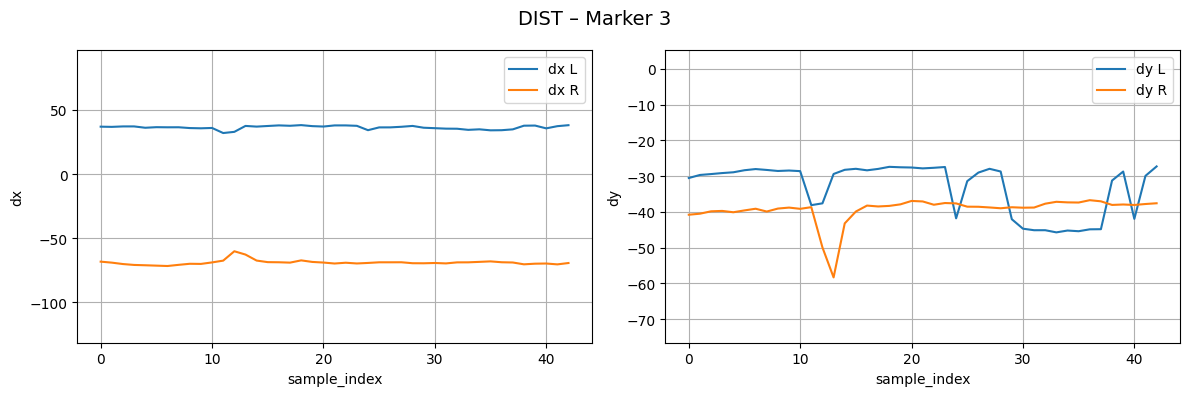

## Marker type: **DIST**, marker_id: **4**

**Data preview:**

,sample_index,dx_L,dy_L,dx_R,dy_R
0,0,38.875919,-26.456506,-70.144428,-37.199963
1,1,38.615865,-26.711634,-70.748461,-36.836600
2,2,40.436725,-26.019501,-71.715935,-37.002417
3,3,41.009771,-26.052924,-71.584794,-36.492647
4,4,40.207900,-24.650658,-72.196727,-33.369954


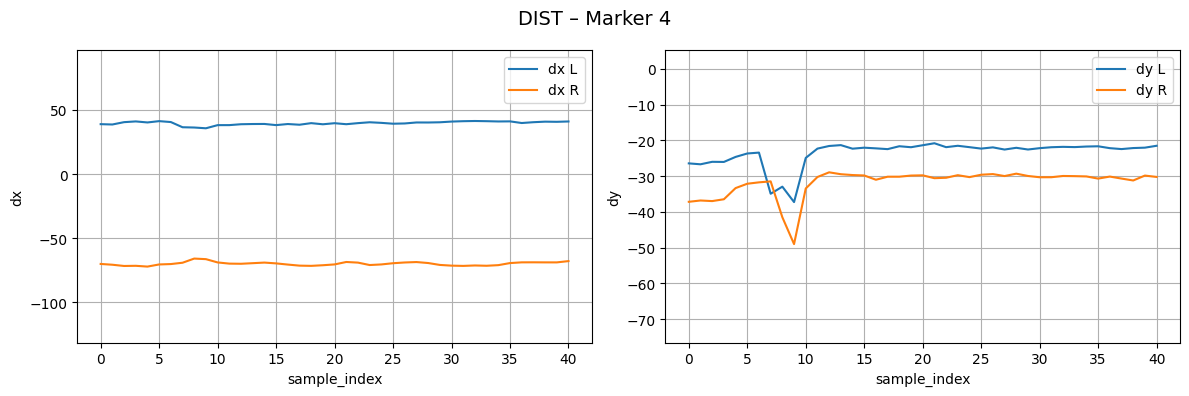

## Marker type: **DIST**, marker_id: **5**

**Data preview:**

,sample_index,dx_L,dy_L,dx_R,dy_R
0,0,43.359803,-22.790584,-69.248006,-31.672059
1,1,44.122955,-22.619513,-70.068111,-30.021444
2,2,44.577662,-21.278124,-71.798501,-28.932715
3,3,44.299904,-17.685130,-73.583863,-25.795905
4,4,44.277156,-16.961174,-73.371231,-24.290401


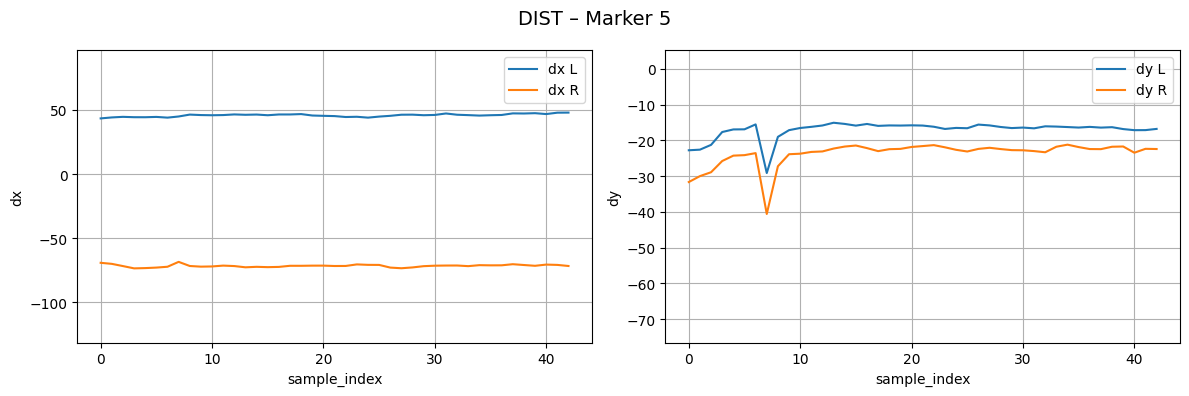

## Marker type: **DIST**, marker_id: **6**

**Data preview:**

,sample_index,dx_L,dy_L,dx_R,dy_R
0,0,47.942601,-17.130749,-71.261522,-24.294276
1,1,48.799742,-16.808780,-71.114724,-24.686212
2,2,49.987847,-16.891188,-72.485061,-24.084443
3,3,48.763471,-22.158418,-74.998829,-15.208095
4,4,50.150626,-9.164348,-76.541346,-11.809812


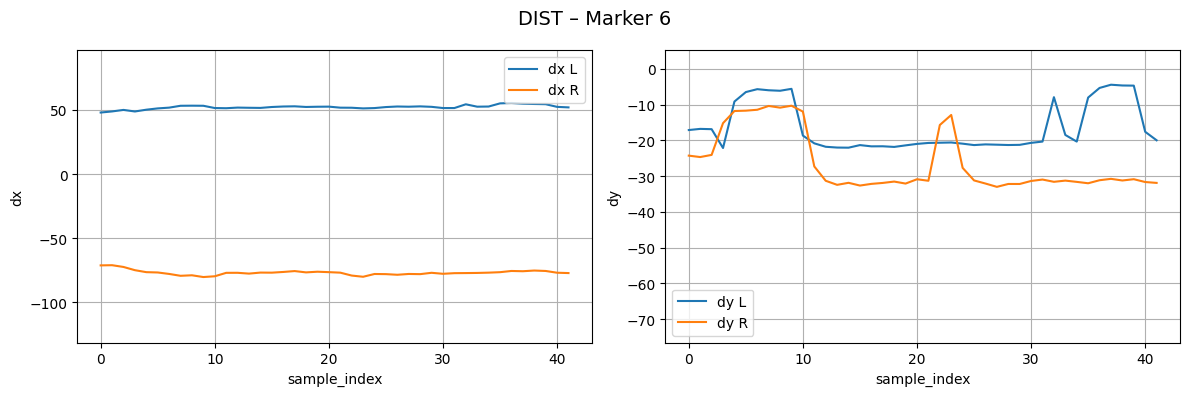

## Marker type: **ANG**, marker_id: **7**

**Data preview:**

,sample_index,dx_L,dy_L,dx_R,dy_R
0,0,50.235038,-17.244251,-71.138207,-28.875784
1,1,49.517334,-17.255932,-70.038087,-28.492296
2,2,49.818204,-15.107484,-59.897013,-28.038148
3,3,74.661335,-31.946857,-27.516113,-30.001455
4,4,80.931515,-22.099782,-21.134736,-30.645322


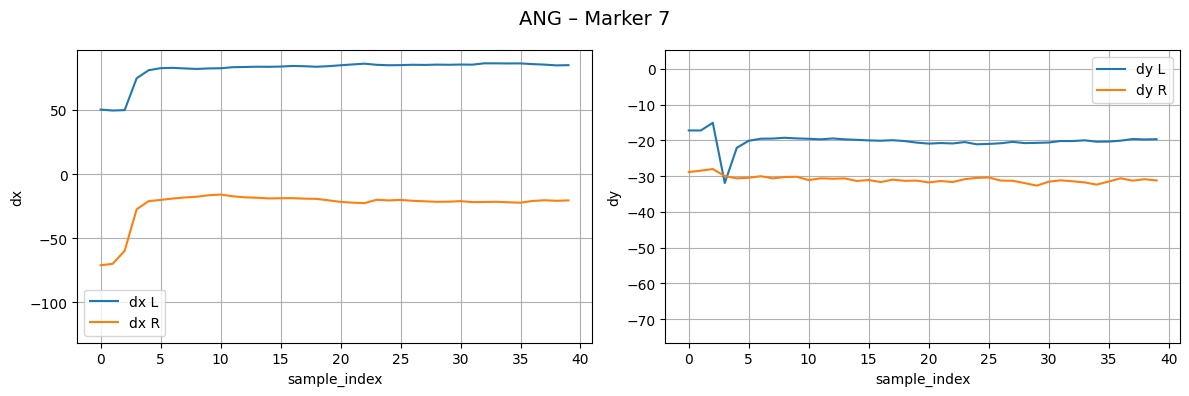

## Marker type: **ANG**, marker_id: **8**

**Data preview:**

,sample_index,dx_L,dy_L,dx_R,dy_R
0,0,53.975075,-19.041348,-52.917376,-29.982795
1,1,53.460117,-19.170979,-52.934842,-29.534392
2,2,53.637686,-19.115326,-53.798974,-29.604107
3,3,54.372569,-19.305973,-54.719066,-30.220552
4,4,54.011261,-19.167176,-54.297623,-29.707342


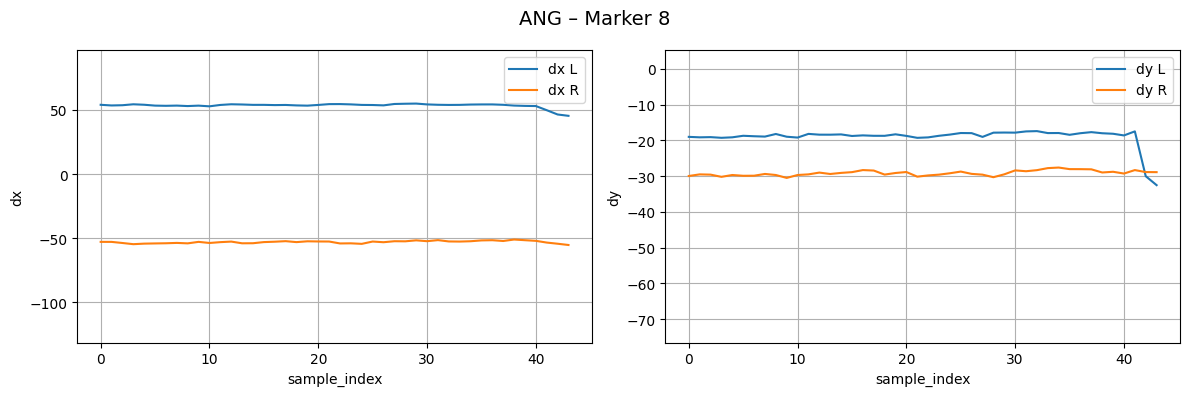

## Marker type: **ANG**, marker_id: **9**

**Data preview:**

,sample_index,dx_L,dy_L,dx_R,dy_R
0,0,45.244890,-18.443653,-58.743546,-29.997213
1,1,25.124511,-25.139759,-75.175520,-28.346152
2,2,23.649742,-27.704679,-79.380553,-28.132617
3,3,26.290217,-16.316473,-80.968391,-28.644733
4,4,25.003657,-15.328933,-81.107576,-28.405470


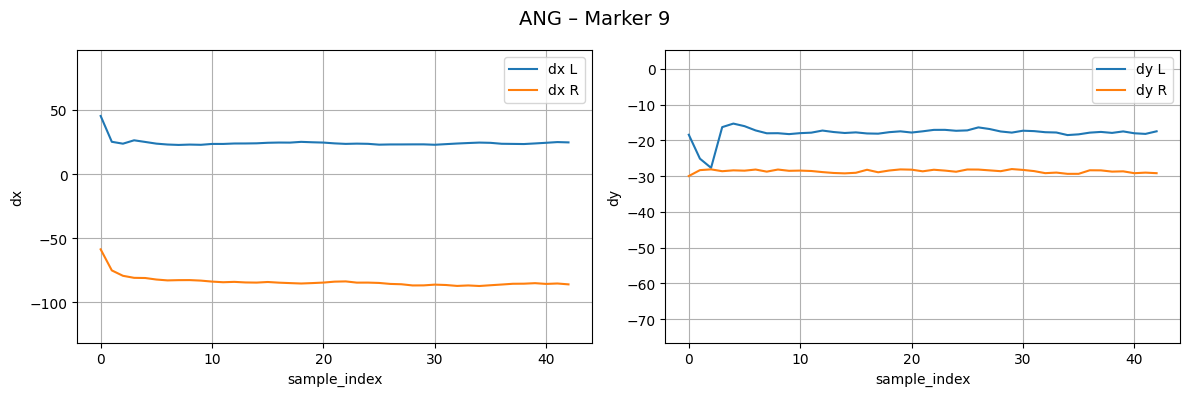

## Marker type: **ANG**, marker_id: **10**

**Data preview:**

,sample_index,dx_L,dy_L,dx_R,dy_R
0,0,6.827693,-23.535437,-108.987393,-25.479995
1,1,0.686794,-22.735832,-114.270940,-25.205153
2,2,-0.885226,-22.858210,-115.858835,-24.945072
3,3,-2.951576,-21.613969,-115.879385,-25.428230
4,4,-3.082895,-22.507916,-116.000138,-24.838268


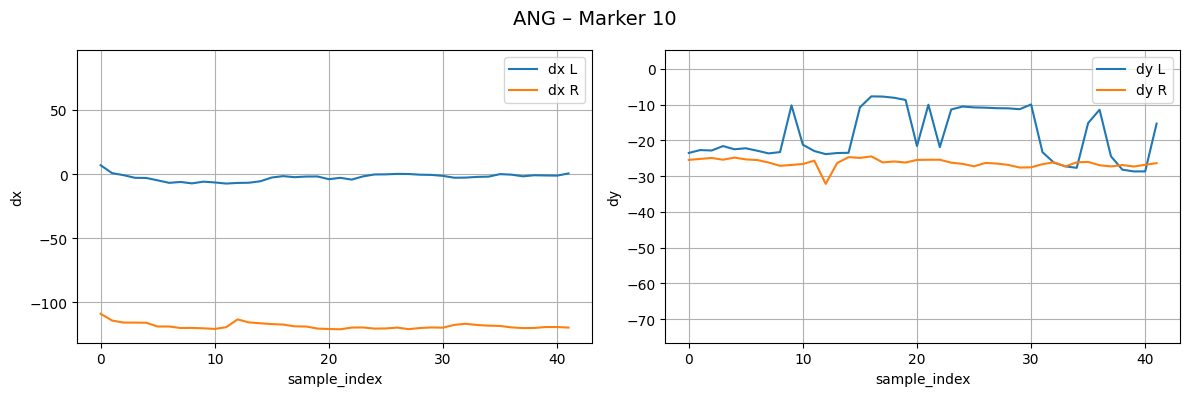

## Marker type: **ANG**, marker_id: **11**

**Data preview:**

,sample_index,dx_L,dy_L,dx_R,dy_R
0,0,41.194568,-42.774142,-71.698865,-56.228495
1,1,42.622209,-43.922912,-71.106274,-57.535339
2,2,42.235595,-44.475949,-69.883112,-57.568414
3,3,41.587145,-53.020876,-69.205254,-67.460896
4,4,42.254385,-56.420786,-70.055445,-71.385251


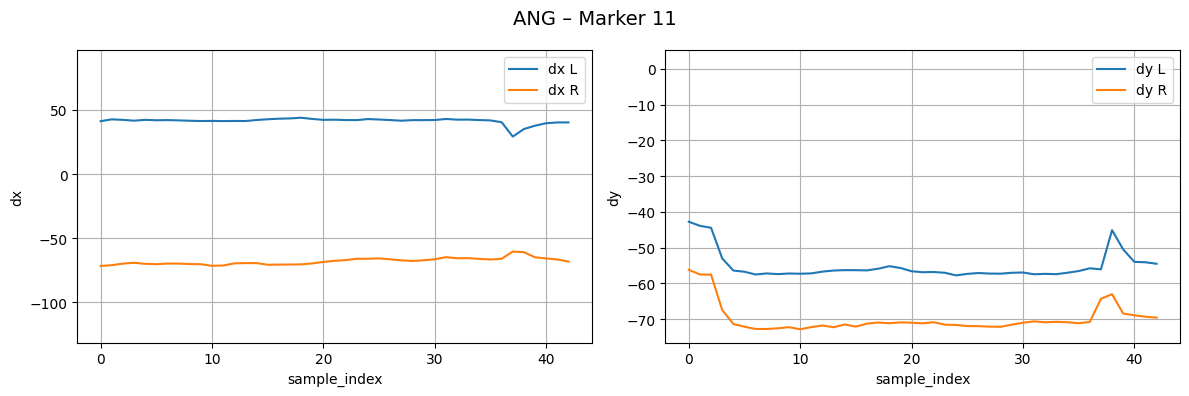

## Marker type: **ANG**, marker_id: **12**

**Data preview:**

,sample_index,dx_L,dy_L,dx_R,dy_R
0,0,41.480545,-52.202127,-68.239425,-66.788397
1,1,39.905777,-40.242758,-67.430356,-55.452419
2,2,40.159579,-34.479755,-66.969826,-46.671287
3,3,39.777052,-33.310721,-67.675544,-44.986145
4,4,40.398890,-32.415075,-68.362715,-44.994859


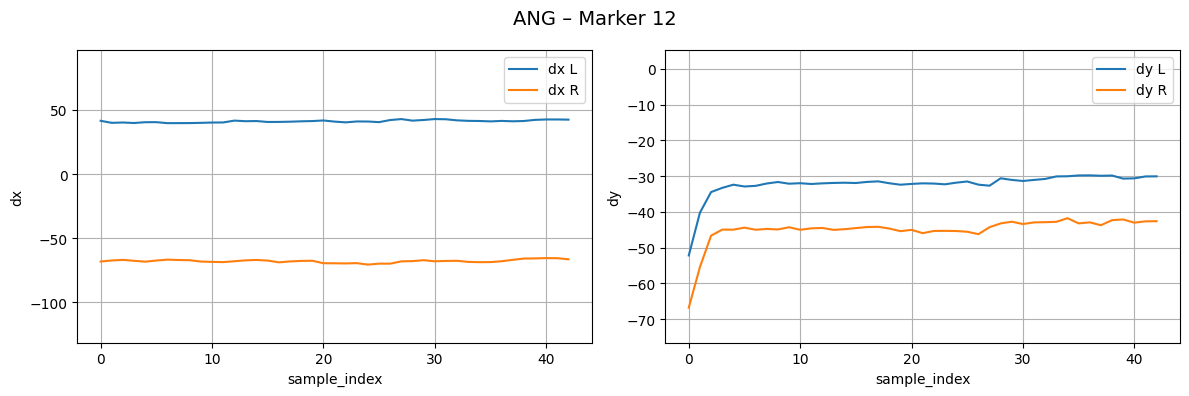

## Marker type: **ANG**, marker_id: **13**

**Data preview:**

,sample_index,dx_L,dy_L,dx_R,dy_R
0,0,55.350211,-4.795584,-82.091764,-16.053251
1,1,56.815672,-1.390386,-81.946756,-14.209121
2,2,58.665402,0.259667,-81.572134,-14.450450
3,3,57.177843,-0.566998,-82.252577,-14.600936
4,4,56.152877,-1.579420,-82.399421,-14.596944


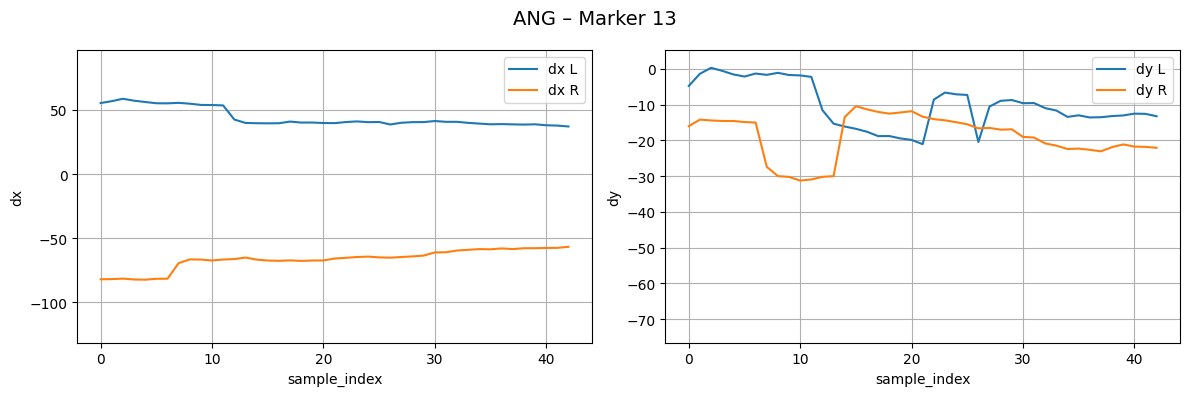

## Marker type: **ANG**, marker_id: **14**

**Data preview:**

,sample_index,dx_L,dy_L,dx_R,dy_R
0,0,38.519974,-20.417305,-61.956557,-18.254075
1,1,32.619523,-17.024168,-62.304960,-13.547694
2,2,35.707157,-12.436779,-62.902370,-10.492945
3,3,34.279438,-11.874562,-62.409263,-10.152090
4,4,33.172285,-12.886445,-62.049295,-9.695013


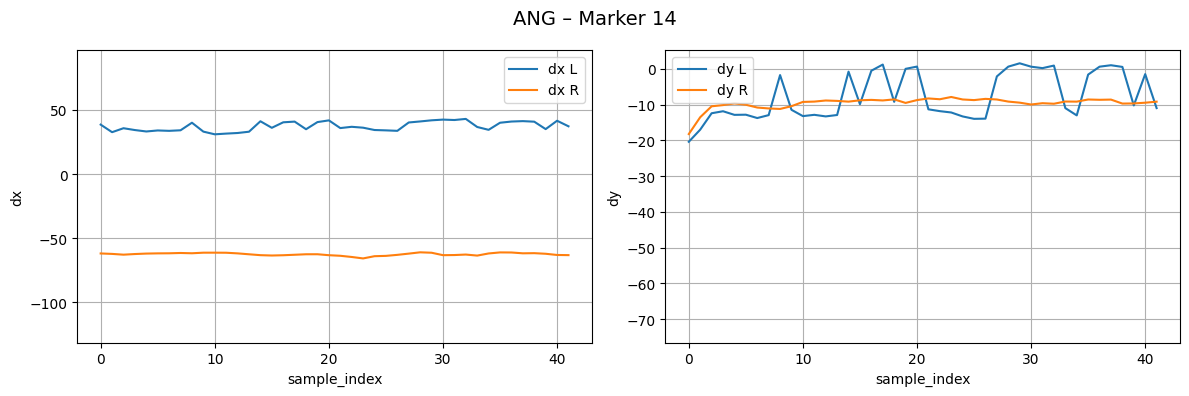

In [21]:
for g in groups:
    mtype = g["marker_type"]
    mid = g["marker_id"]
    display(Markdown(f"## Marker type: **{mtype}**, marker_id: **{mid}**"))

    display(Markdown("**Data preview:**"))
    display(g["df_LR"].head())

    plot_group_dx_dy(g)
